In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import re
from copy import deepcopy

In [2]:
domain_list = ["origin", "brightness", "contrast", "defocus_blur", "gaussian_noise", ]
checkitew_list = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper", ]
metric = "AUPRC"

dir_path = '../results/MVTEC/devnet/4domain'
dir_path = '../results/MVTEC/DGAD/method13_MVTEC'

dir_path = '../results/MVTEC/DGAD/method16'
# dir_path = '../results/MVTEC/DGAD/method16_severity5'
# dir_path = '../results/MVTEC/devnet/4domain_s5'
# dir_path = '../results/MVTEC/devnet/4domain'

# dir_path = '../results/MVTEC/DGAD/method16_transistor'
# dir_path = '../results/MVTEC/DGAD/method16_transistor_lambda'
# dir_path = '../results/MVTEC/DGAD/method16_toothbrush_lambda'
# dir_path = '../results/MVTEC/DGAD/method16_transistor_tau'
dir_path = '../results/MVTEC/DGAD/method16_toothbrush_tau'

# dir_path = '../results/MVTEC/DGAD/method16_transistor_tau_lambda'
dir_path = '../results/MVTEC/devnet/1domain'

In [3]:
import itertools
# normal_class=["0", "1", "2", "3", "4", "5", "6"]
# normal_class=["0 1 2 3", "4 5 6", "0 2 4 6", "1 3 5", "0", "1", "2", "3", "4", "5", "6"]
# anomaly_class=["4 5 6", "0 1 2 3", "1 3 5", "0 2 4 6", "1 2 3 4 5 6", "0 2 3 4 5 6", "0 1 3 4 5 6", "0 1 2 4 5 6", "0 1 2 3 5 6", "0 1 2 3 4 6", "0 1 2 3 4 5"]
# epochs_list=[5, 10, 15, 20, 30]
# lr_list=[0.01, 0.001, 0.0005, 0.0002, 0.00005, 0.00001]
reg_lambda=[1,2,5,10]
NCE_lambda=[1,2,5,10]
PL_lambda=[1,2,5,10]
# cnt=[0,1,2,3,4]
cnt=[0]
all_para_list = list(itertools.product(reg_lambda, NCE_lambda, PL_lambda, cnt))
print(len(all_para_list))
all_para_list[0]

64


(1, 1, 1, 0)

In [4]:
ans = []
# para_name_list=["checkitew", "pre_lr", "pre_epochs", "lr", "epochs", "cnt"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2"]
para_name_list=["checkitew", "lr", "epochs", "cnt",]
if dir_path.__contains__("lambda"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "reg_lambda", "NCE_lambda", "PL_lambda", "class_lambda"]
if dir_path.__contains__("tau"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2", "batch_size"]
# para_name_list=["checkitew", "lr", "epochs", "cnt","reg_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2", "reg_lambda", "NCE_lambda", "PL_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "origin_svdd_lambda", "class_svdd_lambda", "align_lambda", "beta"]
print(len(os.listdir(dir_path)))
for file_name in os.listdir(dir_path):
    record = []
    data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
    max_epoch = data["val_max_metric"].item()["epoch"]
    # max_epoch = [i for i, val in enumerate(data[f"val_{metric}_list"]) if (val == max(data[f"val_{metric}_list"]))][-1]
    
    for key in para_name_list:
        if key in data["args"].item():
            record.append(data["args"].item()[key])
        else:
            record.append(1.0)
    
    record.append(max_epoch)

    if "metric" in data["val_max_metric"].item():
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUROC"])
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUPRC"])
    else:
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUROC"])
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUPRC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUROC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUPRC"])

    record.append(file_name)
    ans.append(record)

ans = pd.DataFrame(ans,columns=para_name_list + ["max_val_epoch"] +\
             [f'{item}_AUROC' for item in domain_list] + \
                [f'{item}_AUPRC' for item in domain_list] +\
                    [f'val_{item}_AUROC' for item in domain_list] +\
                        [f'val_{item}_AUPRC' for item in domain_list] + ["file_name"])

ans["checkitew"] = ans["checkitew"].astype(str)
ans["AUROC_mean"] = ans[[f'{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["AUPRC_mean"] = ans[[f'{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["val_AUROC_mean"] = ans[[f'val_{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["val_AUPRC_mean"] = ans[[f'val_{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["checkitew"] = ans["checkitew"].apply(lambda x :re.sub("\[|\]|,", "", x))
ans.head(5)

540


,checkitew,lr,epochs,cnt,max_val_epoch,origin_AUROC,brightness_AUROC,contrast_AUROC,defocus_blur_AUROC,gaussian_noise_AUROC,...,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,AUROC_mean,AUPRC_mean,val_AUROC_mean,val_AUPRC_mean
0,zipper,0.00001,10,0,1,0,0,0,0,0,...,0.905045,0.783027,0.821764,0.803846,0.850169,"data_name=MVTEC_with_domain_label,backbone=wid...",0.0,0.0,0.573212,0.832770
1,capsule,0.00001,10,1,8,0,0,0,0,0,...,0.921851,0.918389,0.881890,0.864134,0.837160,"data_name=MVTEC_with_domain_label,backbone=wid...",0.0,0.0,0.621902,0.884685
2,capsule,0.00001,30,0,20,0,0,0,0,0,...,0.912977,0.911917,0.845160,0.776160,0.881578,"data_name=MVTEC_with_domain_label,backbone=wid...",0.0,0.0,0.587664,0.865558
3,capsule,0.00005,20,0,3,0,0,0,0,0,...,0.950492,0.914446,0.915255,0.919504,0.889216,"data_name=MVTEC_with_domain_label,backbone=wid...",0.0,0.0,0.711743,0.917783
4,leather,0.00050,20,0,0,0,0,0,0,0,...,0.890340,0.775178,0.718877,0.849627,0.874086,"data_name=MVTEC_with_domain_label,backbone=wid...",0.0,0.0,0.539957,0.821622


In [5]:
ans["checkitew"].value_counts()

zipper        36
capsule       36
leather       36
transistor    36
metal_nut     36
pill          36
tile          36
carpet        36
cable         36
wood          36
grid          36
hazelnut      36
screw         36
toothbrush    36
bottle        36
Name: checkitew, dtype: int64

In [6]:
# ans = ans[ans["epochs"] != 2]
# if dir_path.__contains__("devnet"):
#     ans = ans[ans["lr"] != 0.00005]

In [7]:
ans.cnt.value_counts()

0    180
1    180
2    180
Name: cnt, dtype: int64

In [8]:
# pre_epochs_list = [10, 30, 50, 100]
# pre_lr_list = [0.01, 0.001, 0.0001]
# epochs_list = [10, 20, 30]
# lr_list = [0.00001, 0.0001, 0.001]
# cnt = [0, 1]
# all_para_list = list(itertools.product(cnt, pre_epochs_list, pre_lr_list, epochs_list, lr_list))
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["cnt", "pre_epochs", "pre_lr", "epochs", "lr"]].values])
# remain_para = pd.DataFrame(sorted(remain_para), columns=["cnt", "pre_epochs", "pre_lr", "epochs", "lr"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [9]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[(ans["epochs"]==30) & (ans["lr"]==0.00005) & (ans["cnt"] == 0)][["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# # remain_para
# len(remain_para)

In [10]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["normal_class", "epochs", "lr", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["normal_class", "epochs", "lr", "cnt"])
# remain_para.insert(1,"anomaly_class", remain_para.apply(lambda x: re.sub("\{|,|\}","", str(set([0,1,2,3,4,5,6]) - set(map(int, x["normal_class"].split(" "))))), axis=1))
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [11]:
if metric == "AUPRC":
    columns_to_drop = ans.filter(like='AUROC').columns.to_list()
    columns_to_drop.remove("val_AUROC_mean")
else:
    columns_to_drop = ans.filter(like='AUPRC').columns.to_list()
    columns_to_drop.remove("val_AUPRC_mean")
columns_to_drop = columns_to_drop + [f'{item}_{metric}' for item in domain_list] + [f"{metric}_mean"]
ans = ans.drop(columns=columns_to_drop) 
columns_to_drop

['origin_AUROC',
 'brightness_AUROC',
 'contrast_AUROC',
 'defocus_blur_AUROC',
 'gaussian_noise_AUROC',
 'val_origin_AUROC',
 'val_brightness_AUROC',
 'val_contrast_AUROC',
 'val_defocus_blur_AUROC',
 'val_gaussian_noise_AUROC',
 'AUROC_mean',
 'origin_AUPRC',
 'brightness_AUPRC',
 'contrast_AUPRC',
 'defocus_blur_AUPRC',
 'gaussian_noise_AUPRC',
 'AUPRC_mean']

In [32]:
agg_method = {"cnt":["count"],
              "max_val_epoch":["mean", "std"],
              f"val_{metric}_mean":["mean", "std"],}
for item in domain_list:
    agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
total_avg = dict()
for checkitew in checkitew_list:
    checkitew = str(checkitew)
    selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
    # group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
    group_key = list(set(para_name_list) - set(["checkitew", "cnt"]))
    group_key.sort()
    # print(group_key)
    selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
    selected_para = selected_records_anslysis.index[0]
    # print(selected_para)
    selected_records_anslysis

    filter = None
    for idx, item in enumerate(group_key):
        if filter is None:
            filter = selected_records[item] == selected_para[idx]
        else:
            filter = filter & (selected_records[item] == selected_para[idx])
    temp = selected_records[filter].agg(["mean", "std"]).T
    temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
    for key in [f'val_{item}_{metric}' for item in domain_list]:
        print(temp.loc[key]["res"])
        if key not in total_avg:
            total_avg[key] = []
        total_avg[key].append(temp.loc[key]["res"])
    print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
    selected_records[filter]

total_domain_avg = []
for key in [f'val_{item}_{metric}' for item in domain_list]:
    value = total_avg[key]
    total_domain_avg.append(round(np.array(list(map(lambda x: float(x.split("(")[0]), value))).mean(), 2))
    print(total_domain_avg[-1])
print(round(np.mean(total_domain_avg), 2))

/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these colu

99.27(0.58)
99.43(0.5)
98.98(0.38)
98.54(0.98)
99.1(0.97)
99.07(0.46)
90.47(1.03)
89.48(2.85)
81.05(6.55)
88.73(3.11)
93.13(1.51)
88.57(1.98)
92.97(3.08)
95.18(0.69)
94.02(0.01)
89.92(3.86)
91.47(2.15)
92.71(1.63)
92.96(4.43)
71.89(4.93)
88.84(3.77)
93.84(4.64)
94.73(2.81)
88.45(3.97)
83.05(4.74)
75.31(17.86)
90.38(8.98)
88.56(4.5)
72.13(1.04)
81.89(5.1)
97.46(1.0)
88.71(3.74)
97.63(0.57)
96.88(0.58)
97.79(0.15)
95.69(0.74)
91.27(4.91)
82.21(4.92)
83.64(6.98)
97.88(1.34)
94.08(4.28)
89.82(2.13)
98.17(0.68)
96.62(0.09)
96.42(1.96)
95.15(1.07)
96.09(0.62)
96.49(0.58)
95.48(1.97)
91.06(2.87)
91.91(1.5)
95.49(1.06)
93.11(0.51)
93.41(1.12)
94.97(2.85)
83.17(9.64)
88.03(8.81)
94.26(4.3)
89.94(6.71)
90.08(3.67)
96.44(1.48)
82.1(6.08)
92.45(2.74)
95.6(2.11)
95.64(1.04)
92.45(2.1)
84.69(4.78)
82.52(2.77)
79.79(1.66)
79.06(3.43)
81.23(3.29)
81.46(1.9)
88.5(3.54)
75.01(15.14)
68.86(5.88)
75.0(10.77)
84.52(0.95)
78.38(3.87)
98.0(1.16)
92.64(1.25)
78.48(12.81)
95.59(1.87)
97.3(1.03)
92.4(3.17)
99.1

/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_88177/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these colu

In [13]:
# ans[(ans["normal_class"] == normal_class)].sort_values(by="val_AUROC_mean",ascending=False)

In [14]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(list(item))
# remain_para = pd.DataFrame(remain_para)
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)

In [15]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],2])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],3])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],4])
    
# remain_para = pd.DataFrame(remain_para,columns=["normal_class", "anomaly_class", "epochs", "lr", "cnt"])
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [16]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 1, 1, 0),:]

In [17]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 0, 1, 0),:]

In [18]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 0, 0, 0),:]

In [19]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 0, 0, 0, 0),:]

In [20]:
agg_method = {"cnt":["count"],
              "max_val_epoch":["mean", "std"]}
for item in domain_list:
    agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

agg_method[f"val_{metric}_mean"] = ["mean", "std"]
agg_method[f"val_{metric}_mean"] = ["mean", "std"]

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
checkitew = 'pill'
if dir_path.__contains__("transistor"):
    checkitew = 'transistor'
if dir_path.__contains__("toothbrush"):
    checkitew = 'toothbrush'

selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
# group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
group_key = deepcopy(para_name_list)
group_key.remove("checkitew")
group_key.remove("cnt")
print(group_key)
selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
selected_para = selected_records_anslysis.index[0]
print(selected_para)
selected_records_anslysis

['lr', 'epochs']
(0.0001, 30)


cnt max_val_epoch           val_origin_AUPRC            \
               count          mean       std             mean       std   
lr      epochs                                                            
0.00010 30         3      1.000000  1.000000         0.954765  0.019735   
        20         3      1.000000  0.000000         0.973030  0.005808   
        10         3      0.333333  0.577350         0.931259  0.028383   
0.00050 10         3      2.666667  1.527525         0.951419  0.009263   
        20         3      2.333333  1.527525         0.940444  0.013054   
        30         3      5.333333  4.041452         0.914416  0.051415   
0.00005 10         3      0.333333  0.577350         0.929776  0.040159   
        30         3      0.000000  0.000000         0.936642  0.010659   
        20         3      0.000000  0.000000         0.947477  0.007473   
0.00001 10         3      1.666667  1.154701         0.949750  0.012295   
        20         3      1.000000  1.000000         0.945087  0.008421   
        30         3      0.666667  0.577350         0.932809  0.011332   

               val_brightness_AUPRC           val_contrast_AUPRC            \
                               mean       std               mean       std   
lr      epochs                                                               
0.00010 30                 0.910579  0.028701           0.919120  0.014986   
        20                 0.877247  0.053083           0.931553  0.023897   
        10                 0.892362  0.021750           0.920836  0.031153   
0.00050 10                 0.867405  0.071972           0.898970  0.010705   
        20                 0.904874  0.008454           0.873702  0.021264   
        30                 0.909183  0.021823           0.851581  0.047962   
0.00005 10                 0.884751  0.031139           0.875030  0.042619   
        30                 0.881803  0.013748           0.843815  0.025120   
        20                 0.854317  0.016452           0.868425  0.017956   
0.00001 10                 0.876934  0.004686           0.853249  0.019518   
        20                 0.825231  0.025571           0.868006  0.046362   
        30                 0.818982  0.030494           0.843149  0.028745   

               val_defocus_blur_AUPRC           val_gaussian_noise_AUPRC  \
                                 mean       std                     mean   
lr      epochs                                                             
0.00010 30                   0.954866  0.010608                 0.931128   
        20                   0.936728  0.036911                 0.907019   
        10                   0.916932  0.019276                 0.917402   
0.00050 10                   0.935531  0.011917                 0.892260   
        20                   0.910693  0.009767                 0.912236   
        30                   0.915358  0.010443                 0.928318   
0.00005 10                   0.903684  0.047998                 0.904076   
        30                   0.927743  0.019186                 0.901945   
        20                   0.896710  0.016080                 0.910981   
0.00001 10                   0.874333  0.022712                 0.887605   
        20                   0.882502  0.004096                 0.886119   
        30                   0.899880  0.043172                 0.879618   

                         val_AUPRC_mean            
                     std           mean       std  
lr      epochs                                     
0.00010 30      0.005071       0.934092  0.011222  
        20      0.019464       0.925115  0.018036  
        10      0.011947       0.915758  0.004275  
0.00050 10      0.019487       0.909117  0.021267  
        20      0.019417       0.908390  0.005066  
        30      0.011535       0.903771  0.017691  
0.00005 10      0.012196       0.899463  0.025934  
        30      0.021177       0.898390  0.006319  
       

In [21]:
filter = None
for idx, item in enumerate(group_key):
    if filter is None:
        filter = selected_records[item] == selected_para[idx]
    else:
        filter = filter & (selected_records[item] == selected_para[idx])
temp = selected_records[filter].agg(["mean", "std"]).T
temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
for key in [f'val_{item}_{metric}' for item in domain_list]:
    print(temp.loc[key]["res"])
print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
selected_records[filter]

95.48(1.97)
91.06(2.87)
91.91(1.5)
95.49(1.06)
93.11(0.51)
93.41(1.12)


/tmp/ipykernel_88177/1079342940.py:7: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T


,lr,epochs,cnt,max_val_epoch,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,val_AUROC_mean,val_AUPRC_mean
106,0.0001,30,0,0,0.935672,0.877441,0.929383,0.945597,0.925791,"data_name=MVTEC_with_domain_label,backbone=wid...",0.699034,0.922777
345,0.0001,30,1,2,0.975085,0.926811,0.926055,0.966436,0.931710,"data_name=MVTEC_with_domain_label,backbone=wid...",0.764683,0.945219
382,0.0001,30,2,1,0.953538,0.927487,0.901923,0.952564,0.935882,"data_name=MVTEC_with_domain_label,backbone=wid...",0.714289,0.934279


In [22]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

NpzFile '../results/MVTEC/devnet/1domain/data_name=MVTEC_with_domain_label,backbone=wide_resnet50_2,domain_cnt=1,checkitew=pill,batch_size=48,steps_per_epoch=20,epochs=30,lr=0.0001,cnt=0.npz' with keys: val_max_metric, train_results_loss, val_results_loss, val_AUROC_list, val_AUPRC_list...

In [23]:
# # data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
# file_name = 'results/DEBUG/method=10,backbone=DGAD9,domain_cnt=3,normal_class=[0],anomaly_class=[1, 2, 3, 4, 5, 6],batch_size=30,steps_per_epoch=20,epochs=40,lr=5e-05,tau1=0.07,tau2=0.07,origin_svdd_lambda=1.0,class_svdd_lambda=1.0,align_lambda=1.0,beta=0.9,cnt=0.npz'
# data = np.load(f'../{file_name}', allow_pickle=True)
# data

In [24]:
domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

### 训练过程中 模型在test上下降趋势

0
origin [0.9356720692261036, 0.9773385396132189, 0.9804258292045097, 0.9820171006721005, 0.9731919575088086, 0.9828257622076491, 0.9824121146884754]
brightness [0.8774405874482522, 0.917592109476811, 0.9353456821534833, 0.9362636184979709, 0.9368260743318095, 0.9362969692325267, 0.9364173922608534]
contrast [0.9293829916894114, 0.9322334347300181, 0.9155045740741066, 0.9258675523521867, 0.910521137519321, 0.9328807530211252, 0.9298212022401211]
defocus_blur [0.9455973756831126, 0.9590973643239185, 0.9698232198400831, 0.9717202920959808, 0.9528988083176057, 0.9751273978164781, 0.9735872327854822]
gaussian_noise [0.9257909272551621, 0.9378428190356642, 0.9436976464732166, 0.9457185441447705, 0.9454583966713186, 0.9458151483518813, 0.9455048461226199]


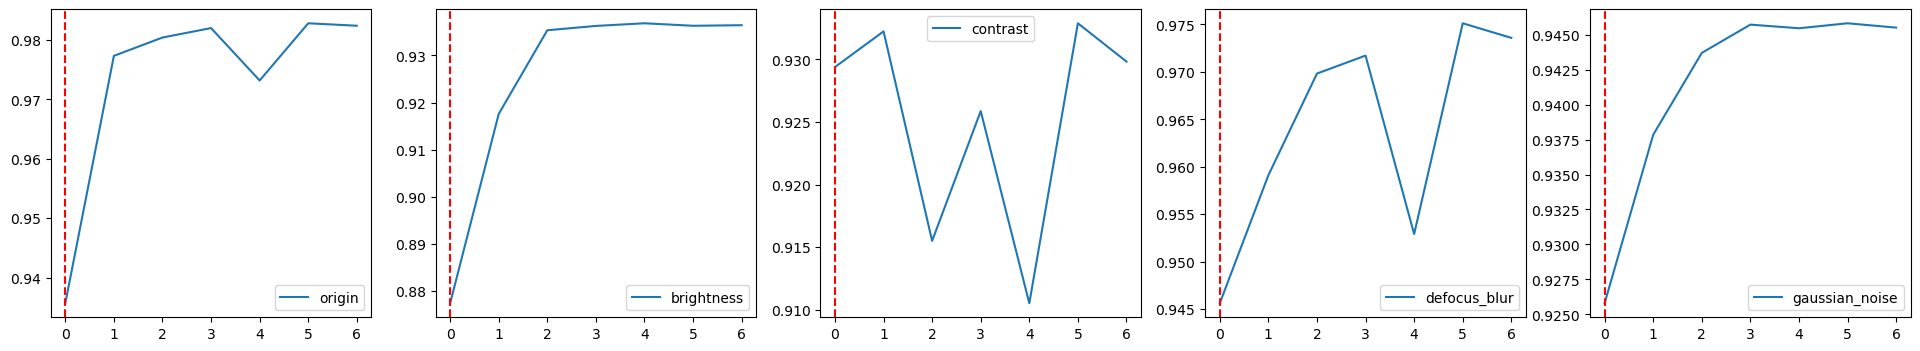

0
origin 0.9356720692261036
brightness 0.8774405874482522
contrast 0.9293829916894114
defocus_blur 0.9455973756831126
gaussian_noise 0.9257909272551621


In [25]:
max_val_epoch = data["val_max_metric"].item()['epoch']
print(max_val_epoch)

fig, ax = plt.subplots(1,5, figsize=(24, 4))

for idx, domain in enumerate(domain_list):
    ax[idx].plot(domain_test_trends[domain][metric], label = domain)
    print(domain, domain_test_trends[domain][metric])

    if "metric" in data["val_max_metric"].item():
        if "test_epoch" in data["args"].item():
            ax[idx].axvline(x=max_val_epoch / data["args"].item()["test_epoch"], color='r', linestyle='--')
        else:
            ax[idx].axvline(x=max_val_epoch / 5, color='r', linestyle='--')
    else:
        ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')

    ax[idx].legend()
plt.show()

print(max_val_epoch)
if "metric" in data["val_max_metric"].item():
    for domain in domain_list:
        print(domain, data["val_max_metric"].item()["metric"][domain][metric])
else:
    for domain in domain_list:
        print(domain, domain_test_trends[domain][metric][max_val_epoch])

In [26]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

tmp = []
for idx, domain in enumerate(domain_list):
    tmp.append(domain_test_trends[domain][metric])
tmp = pd.DataFrame(tmp, index=domain_list)
idx = tmp.mean(axis = 0).idxmax()
print(idx)
pd.concat([tmp, pd.DataFrame(tmp.mean(axis = 0), columns = ["avg"]).T])

5


,0,1,2,3,4,5,6
origin,0.935672,0.977339,0.980426,0.982017,0.973192,0.982826,0.982412
brightness,0.877441,0.917592,0.935346,0.936264,0.936826,0.936297,0.936417
contrast,0.929383,0.932233,0.915505,0.925868,0.910521,0.932881,0.929821
defocus_blur,0.945597,0.959097,0.969823,0.971720,0.952899,0.975127,0.973587
gaussian_noise,0.925791,0.937843,0.943698,0.945719,0.945458,0.945815,0.945505
avg,0.922777,0.944821,0.948959,0.952317,0.943779,0.954589,0.953549


### 训练集loss下降趋势

array([0.3078806 , 0.0249231 , 0.0154458 , 0.01978648, 0.00678063,
       0.00776855, 0.00641918, 0.00664057, 0.00453317, 0.00490452,
       0.00475537, 0.00579317, 0.00515443, 0.00765688, 0.00563728,
       0.00535512, 0.00438434, 0.00509735, 0.00537366, 0.00579707,
       0.00624491, 0.00713355, 0.00497581, 0.0051272 , 0.00784133,
       0.00702606, 0.00825979, 0.00609345, 0.00519303, 0.00470865])

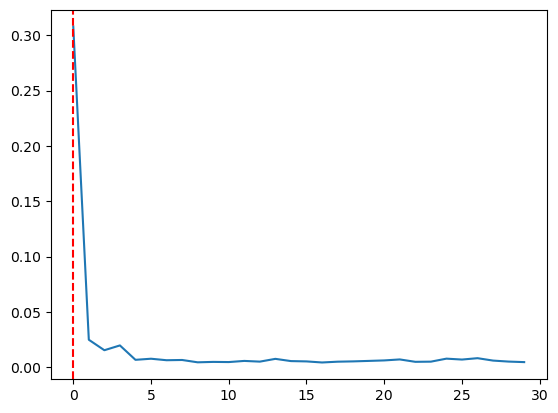

In [27]:
plt.plot(data["train_results_loss"].mean(axis=1)[0:])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["train_results_loss"].mean(axis=1)

### 训练过程中，模型在val 下降趋势

#### 验证集loss下降趋势

array([0.40077296, 0.39304902, 0.36202637, 0.35828861, 0.37151008,
       0.36822703, 0.36265752, 0.36634841, 0.36491869, 0.37832299,
       0.37130524, 0.379047  , 0.36304888, 0.36456069, 0.36632443,
       0.36332525, 0.37357731, 0.36146944, 0.37062916, 0.37150768,
       0.36288325, 0.37891633, 0.37703157, 0.3764821 , 0.36533321,
       0.36441465, 0.36906654, 0.36948086, 0.36337511, 0.36869036])

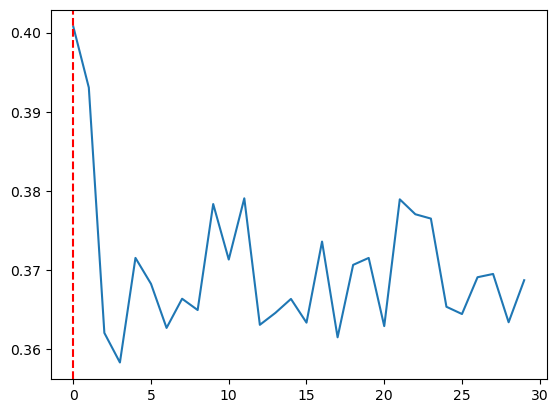

In [28]:
plt.plot(data["val_results_loss"].mean(axis=1))
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["val_results_loss"].mean(axis=1)

#### 验证集AUROC

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.98148148, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

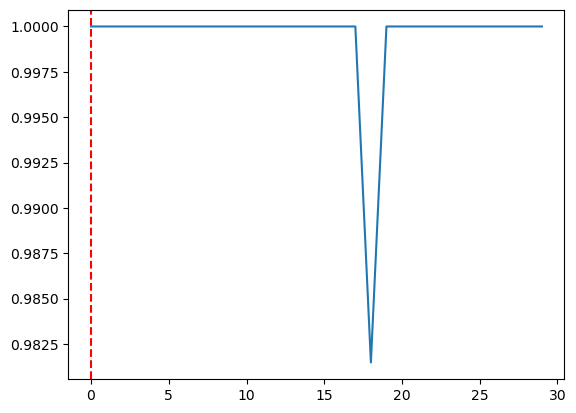

In [29]:
plt.plot(data[f"val_AUROC_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_AUROC_list"]

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. ])

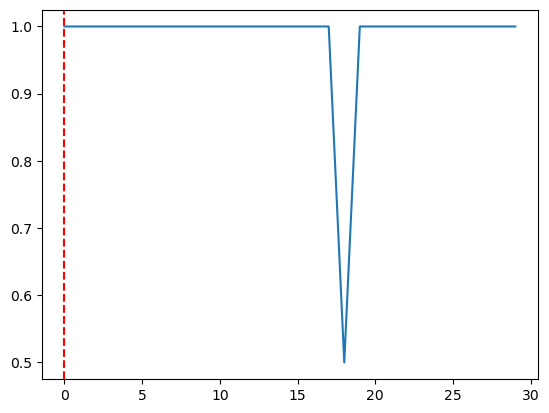

In [30]:
plt.plot(data[f"val_{metric}_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_{metric}_list"]

In [31]:
temp = data["sub_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(temp.shape[1],1,figsize=(10,2.5 * temp.shape[1]))
if dir_path.__contains__("method13"):
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
elif dir_path.__contains__("VAE_LPIPS_DEVNET"):
    loss_name_list = ["rec_loss", "kl_loss", "devnet_loss", "reg_loss", "PL_loss", "class_reg_loss"]
else:
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
for idx, label in enumerate(loss_name_list):
    ax[idx].plot(temp[0:,idx], label=label)
    ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')
    ax[idx].legend()

# for i in range(5):
#     print(temp[0:,i])
print(temp[0:, 1])
plt.show()

KeyError: 'sub_train_results_loss is not a file in the archive'

In [ ]:
temp[0:, 0][-5]

0.005567425514163915

In [ ]:
# data["sub_train_results_loss"].mean(axis=1)

In [ ]:
if "pre_epochs" in para_name_list:
    temp = []
    for item in file_name.split(","):
        if re.match("epochs=|lr=|reg_lambda", item):
            pass
        else:
            temp.append(item)
    data = np.load(f'../experiment/{",".join(temp)}', allow_pickle=True)

In [ ]:
plt.plot(data["pre_train_results_loss"].mean(axis=1))

KeyError: 'pre_train_results_loss is not a file in the archive'

In [ ]:
temp = data["sub_pre_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(2,1,figsize=(6, 6))
ax[0].plot(temp[0:,0], label="NCE_loss")
ax[1].plot(temp[0:,1], label="PL_loss") 
ax[0].legend()
ax[1].legend()
plt.show()

KeyError: 'sub_pre_train_results_loss is not a file in the archive'

In [ ]:
temp[0:,0]

array([5.12366613e-02, 7.52512779e-04, 2.38156579e-04, 1.11763124e-04,
       9.64891620e-05, 7.81198205e-05, 7.47454518e-05, 6.63250018e-05,
       5.95974552e-05, 5.38587965e-05, 5.10202187e-05, 4.65418390e-05,
       4.23788977e-05, 4.13187449e-05, 4.01404671e-05, 3.87827890e-05,
       3.81627700e-05, 3.65760899e-05, 3.56698465e-05, 3.59697684e-05,
       3.47524817e-05, 3.46994501e-05, 3.51303973e-05, 3.37718926e-05,
       3.41283220e-05, 3.38422307e-05, 3.38356650e-05, 3.35584650e-05,
       3.30837758e-05, 3.34783733e-05])

In [ ]:
temp[0:,1]

array([4.97540535e-01, 1.41077568e-01, 2.41149376e-02, 4.21630200e-02,
       5.27702281e-02, 4.10839084e-02, 4.46073550e-02, 3.27919084e-03,
       1.01064351e-03, 1.06021749e-04, 5.06643846e-05, 2.74663981e-05,
       2.02918835e-05, 1.68948272e-05, 1.48062682e-05, 1.33578818e-05,
       1.22908901e-05, 1.14740167e-05, 1.08376776e-05, 1.03394184e-05,
       9.94086144e-06, 9.62827937e-06, 9.38167218e-06, 9.19360803e-06,
       9.04976189e-06, 8.94778285e-06, 8.87626526e-06, 8.83177576e-06,
       8.80642324e-06, 8.79488158e-06])